In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.zip to train.zip
User uploaded file "train.zip" with length 194592601 bytes


In [0]:
!unzip train.zip

Archive:  train.zip
   creating: train_articles/
  inflating: train.json              
  inflating: train_articles/55701.txt  
  inflating: train_articles/134107.txt  
  inflating: train_articles/45107.txt  
  inflating: train_articles/89894.txt  
  inflating: train_articles/123173.txt  
  inflating: train_articles/86133.txt  
  inflating: train_articles/9062.txt  
  inflating: train_articles/91887.txt  
  inflating: train_articles/93338.txt  
  inflating: train_articles/60364.txt  
  inflating: train_articles/58197.txt  
  inflating: train_articles/152215.txt  
  inflating: train_articles/111602.txt  
  inflating: train_articles/97543.txt  
  inflating: train_articles/101058.txt  
  inflating: train_articles/57647.txt  
  inflating: train_articles/63102.txt  
  inflating: train_articles/58351.txt  
  inflating: train_articles/111310.txt  
  inflating: train_articles/77728.txt  
  inflating: train_articles/14417.txt  
  inflating: train_articles/110546.txt  
  inflating: train_articles

In [0]:
!ls

sample_data  train_articles  train.json  train.zip


# Load metadata

This assumes that the file train.zip has been unzipped in the current directory.  If needed, insert code here to load the data from your computer.

In [0]:
import json
import numpy as np


# load metadata
with open("train.json", 'r') as f:
    metadata = json.load(f)
n_claims = len(metadata)

# RNN architecture

We define a simple RNN that processes one token at time to update a hidden vector.  The last hidden vector is passed to a classifier that uses a softmax to predict the category.

In [0]:
import torch
import torch.nn as nn
import numpy as np
import random

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
      
class Classifier(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Classifier, self).__init__()
        self.hidden_size = hidden_size
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2o(hidden)
        output = self.softmax(hidden)
        return output

# Sample a claim
Sample a claim, tokenize it and embed it.

In [0]:
!pip install bpemb
from bpemb import BPEmb

     |████████████████████████████████| 1.0MB 9.5MB/s 


In [0]:
n_embedding_dims = 50
bpemb_en = BPEmb(lang="en", dim=n_embedding_dims)

def sampleClaim(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"]
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id



downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 1924908/1924908 [00:00<00:00, 15872045.63B/s]

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d50.w2v.bin.tar.gz



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def sampleClaimAndClaimant(metadata): 
    id = random.randint(0, len(metadata) - 1)
    claim = metadata[id]["claim"] + ' ' + metadata[id]["claimant"]
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

# Training procedure


In [0]:
def train(category_tensor, line_tensor, update=True):
    rnnOptimizer.zero_grad()
    classifierOptimizer.zero_grad()

    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        hidden = rnn(line_tensor[i], hidden)
    output = classifier(hidden)

    loss = criterion(output, category_tensor)
    if update:
        loss.backward()
        rnnOptimizer.step()
        classifierOptimizer.step()
        
    return output, loss.item()

# Train RNN and plot results





Train: 1000  1% (0m 8s) average_accuracy=0.5080 average_loss=0.9882  "PELOSI EXPLAINS THE LEFT’S ANTI-KAVANAUGH STRATEGY."  / 0 ✓
Test: 1000  1% (0m 8s) average_accuracy=0.5170 average_loss=0.9671 Hillary Clinton was fired from the House Judiciary Committee's Watergate investigation by Chief Counsel Jerry Zeifman. / 0 ✓
Train: 2000  2% (0m 15s) average_accuracy=0.5690 average_loss=0.8875 Left-handed people die younger than right-handed people. / 0 ✓
Test: 2000  2% (0m 15s) average_accuracy=0.5460 average_loss=0.9132 Prayers are needed for the city of Queragosh (Qaraqosh), which has fallen to ISIS and is seeing Christian children being beheaded in large numbers. / 0 ✗ (1)
Train: 3000  3% (0m 23s) average_accuracy=0.5800 average_loss=0.9282 John McCain wants to "give oil companies another $4-billion" in tax breaks. / 0 ✗ (2)
Test: 3000  3% (0m 23s) average_accuracy=0.5400 average_loss=0.9411 "The domestic media are disseminating reports about the 'sending' to Syria of 'servicemen' from t

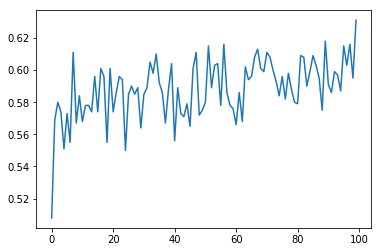

In [0]:
import time
import math

n_hidden = 128
n_categories = 3
rnn = RNN(n_embedding_dims, n_hidden)
classifier = Classifier(n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]
train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0
all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []
count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaim(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaim(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        all_train_losses.append(train_cumulative_loss / plot_every)
        all_train_accuracies.append(average_train_accuracy)
        all_test_losses.append(test_cumulative_loss / plot_every)
        all_test_accuracies.append(average_test_accuracy)
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_accuracies)

Train: 1000  1% (0m 8s) average_accuracy=0.5380 average_loss=0.9513  "We’re really increasing [stock] values. And maybe in a sense we’re reducing debt."  Donald Trump / 0 ✓
Test: 1000  1% (0m 8s) average_accuracy=0.5280 average_loss=0.9503 President Donald Trump's administration said that employers are allowed to fire workers if they are gay.  / 0 ✗ (1)
Train: 2000  2% (0m 15s) average_accuracy=0.5620 average_loss=0.9219 "Every member of Congress, they pay for their own insurance, too. We are put into the exchange. We’re not a federal employee. We go into the D.C. exchange and we personally have to pay for 100 percent of it." Markwayne Mullin (R-Okla.) / 0 ✗ (1)
Test: 2000  2% (0m 15s) average_accuracy=0.5770 average_loss=0.9270 Says Dallas Cowboys owner Jerry Jones told players: "Stand for the Anthem or you’re off team." Greg Abbott / 1 ✗ (0)
Train: 3000  3% (0m 23s) average_accuracy=0.5820 average_loss=0.9261 Says she debated her opponent "multiple times." Nancy McFarlane / 1 ✓
Test:

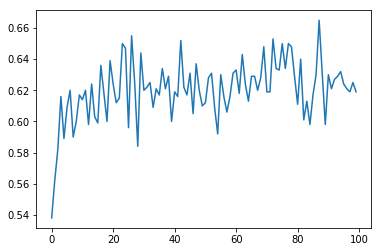

In [0]:
n_hidden = 128
n_categories = 3
rnn = RNN(n_embedding_dims, n_hidden)
classifier = Classifier(n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]
train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0
all_train_losses_2 = []
all_train_accuracies_2 = []
all_test_losses_2 = []
all_test_accuracies_2 = []
count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimAndClaimant(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimAndClaimant(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        all_train_losses_2.append(train_cumulative_loss / plot_every)
        all_train_accuracies_2.append(average_train_accuracy)
        all_test_losses_2.append(test_cumulative_loss / plot_every)
        all_test_accuracies_2.append(average_test_accuracy)
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        

plt.figure()
plt.plot(all_train_accuracies_2)

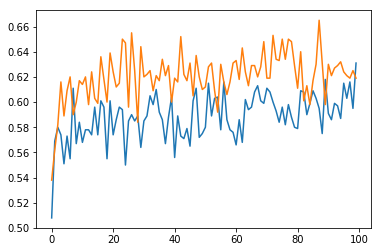

In [0]:
plt.figure()
plt.plot(all_train_accuracies)
plt.plot(all_train_accuracies_2)

# Preprocess articles

This code preprocesses the aticles to extract the top 5 sentences with greatest similarity to the claim according to tf-idf.

In [0]:
def preprocess_articles():

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):
  
        if id % 500 == 0:
            print("Claims preprocessed: ",id)
        
        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)
    
        # measure similarity between claim and each sentence
        similarity =  X[-1,:] @ np.transpose(X[:-2,:])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1,min(5,sorted_index.shape[1])+1):
            top_sentences.append(sentences[sorted_index[0,-i]])
        relevant_sentences.append(top_sentences)

   
    return metadata, relevant_sentences

metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim 0:
A

In [0]:
print(" ".join(relevant_sentences[0]))

1984 by George Orwell
1984 is a dystopian novel by English author George Orwell published in 1949. Theater Review: '1984'
Early this year, sales of George Orwell's novel "1984" spiked after the words "alternative facts" entered the lexicon. It is truly frightening to see the parallels between George Orwell's dystopian novel "1984" and the state of our union today. 
1984: George Orwell predicted 2017 almost 70 years ago
April, 1984. The line is from one of the characters that works for the Government, otherwise known as Big Brother.


In [0]:
def sampleClaimClaimantRelevantSentences(metadata): 
    id = random.randint(0, len(metadata) - 1)
    top_related_sentences = " ".join(relevant_sentences[id])
    claim = metadata[id]["claim"] + ' ' + metadata[id]["claimant"] + ' ' + top_related_sentences
    embedding = bpemb_en.embed(claim)
    embedding = np.reshape(embedding,(embedding.shape[0],1,embedding.shape[1]))
    label = metadata[id]["label"]
    label_tensor = torch.tensor([label], dtype=torch.long)
    claim_tensor = torch.tensor(embedding, dtype=torch.float)
    return claim_tensor, label_tensor, claim, label, id

Train: 1000  1% (0m 56s) average_accuracy=0.4440 average_loss=1.0110 The average rate of growth of the economy ever since 1986 has been 6.3% per annum Yoweri Museveni The industrial sector has experienced steady growth over the last decade, at an average of 7 per cent per annum. Against this background the recent performance of the Ugandan economy is impressive—GDP growth averaged 6.5 per cent per annum in the 1990s and 2000s. Against this background the recent performance of the Ugandan economy is impressive—GDP growth averaged 6.5 per cent per annum in the 1990s and 2000s. The growth rate of real GDP is often used as an indicator of the general health of the economy. The adoption of a conservative monetary policy, and the restoration of the productive capacity of the economy have resulted in a decline in the inflation rate from a peak of 250 per cent in 1987 to an average of less than 5 per cent between 2000 and 2010.10 The fiscal deficit, on the other hand, has continued to increase

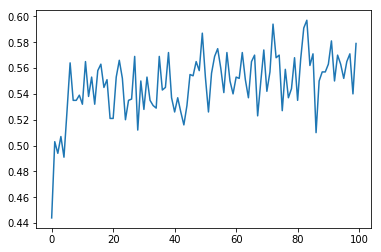

In [0]:
n_hidden = 128
n_categories = 3
rnn = RNN(n_embedding_dims, n_hidden)
classifier = Classifier(n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 1e-4
rnnOptimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
classifierOptimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

n_iters = 100000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

train_data = metadata[:10000]
test_data = metadata[10000:]

train_cumulative_loss = 0
test_cumulative_loss = 0
average_train_accuracy = 0
average_test_accuracy = 0

all_train_losses_3 = []
all_train_accuracies_3 = []
all_test_losses_3 = []
all_test_accuracies_3 = []

count = 0
for iter in range(1, n_iters + 1):
    train_line_tensor, train_category_tensor, train_line, train_category, train_id = sampleClaimClaimantRelevantSentences(train_data)
    train_output, train_loss = train(train_category_tensor, train_line_tensor)    
    top_train_value, top_train_index = train_output.topk(1)
    train_guess_category = top_train_index[0].item()
    train_cumulative_loss += train_loss
    train_accuracy = 1 if train_guess_category == train_category else 0
    average_train_accuracy = (average_train_accuracy * count + train_accuracy) / (count+1)
    
    test_line_tensor, test_category_tensor, test_line, test_category, test_id = sampleClaimClaimantRelevantSentences(test_data)
    test_output, test_loss = train(test_category_tensor, test_line_tensor, update=False)
    top_test_value, top_test_index = test_output.topk(1)
    test_guess_category = top_test_index[0].item()
    test_cumulative_loss += test_loss
    test_accuracy = 1 if test_guess_category == test_category else 0
    average_test_accuracy = (average_test_accuracy * count + test_accuracy) / (count+1)
    count += 1

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        train_correct = '✓' if train_guess_category == train_category else '✗ (%s)' % train_category
        print('Train: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_train_accuracy, train_cumulative_loss / plot_every, train_line, train_guess_category, train_correct))
        test_correct = '✓' if test_guess_category == test_category else '✗ (%s)' % test_category
        print('Test: %d  %d%% (%s) average_accuracy=%.4f average_loss=%.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), average_test_accuracy, test_cumulative_loss / plot_every, test_line, test_guess_category, test_correct))
        
        all_train_losses_3.append(train_cumulative_loss / plot_every)
        all_train_accuracies_3.append(average_train_accuracy)
        all_test_losses_3.append(test_cumulative_loss / plot_every)
        all_test_accuracies_3.append(average_test_accuracy)
        
        train_cumulative_loss = 0
        average_train_accuracy = 0
        test_cumulative_loss = 0
        average_test_accuracy = 0
        count = 0
        

plt.figure()
plt.plot(all_train_accuracies_3)

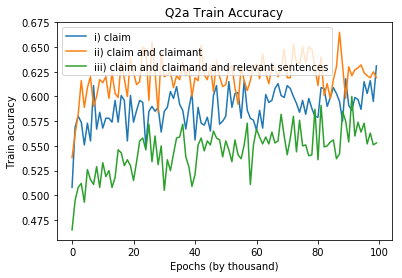

In [0]:
plt.figure()
plt.plot(all_train_accuracies)
plt.plot(all_train_accuracies_2)
plt.plot(all_train_accuracies_3)
plt.title('Q2a Train Accuracy')
plt.ylabel('Train accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['i) claim', 'ii) claim and claimant', 'iii) claim and claimand and relevant sentences'], loc='upper left')
plt.show()

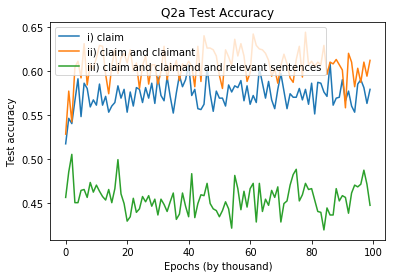

In [0]:
plt.figure()
plt.plot(all_test_accuracies)
plt.plot(all_test_accuracies_2)
plt.plot(all_test_accuracies_3)
plt.title('Q2a Test Accuracy')
plt.ylabel('Test accuracy')
plt.xlabel('Epochs (by thousand)')
plt.legend(['i) claim', 'ii) claim and claimant', 'iii) claim and claimand and relevant sentences'], loc='upper left')
plt.show()